# Route Recommender

Only creating recommendations for Nevada routes since this is the only state we have ratings for at the moment.

Item-Item collaborative filtering using kNN inspired from [this blog post](https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea) and [this blog post](https://towardsdatascience.com/how-did-we-build-book-recommender-systems-in-an-hour-part-2-k-nearest-neighbors-and-matrix-c04b3c2ef55c)

In [1]:
import sys
import os
import time
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import utils

print(time.strftime('%Y/%m/%d %H:%M'))
print('OS:', sys.platform)
print('CPU Cores:', os.cpu_count())
print('Python:', sys.version)
print('NumPy:', np.__version__)
print('Pandas:', pd.__version__)
print('Scikit-Learn:', sklearn.__version__)

%matplotlib inline

2020/01/05 16:14
OS: win32
CPU Cores: 8
Python: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 14:00:49) [MSC v.1915 64 bit (AMD64)]
NumPy: 1.16.4
Pandas: 0.25.0
Scikit-Learn: 0.21.2


In [2]:
df = pd.read_csv('data/nevada-ratings.csv')

# Renaming to be more logical
df.rename({'users': 'user_id', 'ratings': 'rating', 'name': 'route_name'}, axis=1, inplace=True)

print('Dataframe shape:', df.shape)
print('Total number of users:', len(df['user_id'].unique()))
print('Total number of routes:', len(df['route_id'].unique()))
df.head()

Dataframe shape: (84786, 6)
Total number of users: 7949
Total number of routes: 3161


,user_id,rating,route_id,route_name,grade,type
0,0,4.0,117859314,Sword of Wotan,5.12-,trad
1,1,3.0,116561977,Wrath of Sores,5.12c,sport
2,1,3.0,116561849,Waste Not Want Not,5.12b,sport
3,2,3.0,113987936,Scrum Felcher,5.10c,sport
4,3,3.0,113987936,Scrum Felcher,5.10c,sport


In [42]:
# Creating a dataframe for route information
df_routes = df[['route_id', 'route_name', 'grade', 'type']].drop_duplicates()

# Adding additional details
route_summary_statistics = df.groupby('route_id')['rating'].agg(['mean', 'std', 'count'])
route_summary_statistics = route_summary_statistics.add_prefix('route_rating_').reset_index()  # Renaming the columns
df_routes = df_routes.merge(route_summary_statistics)

In [44]:
df_routes.head()

,route_id,route_name,grade,type,route_rating_mean,route_rating_std,route_rating_count
0,117859314,Sword of Wotan,5.12-,trad,4.0,NaN,1
1,116561977,Wrath of Sores,5.12c,sport,3.0,NaN,1
2,116561849,Waste Not Want Not,5.12b,sport,3.0,NaN,1
3,113987936,Scrum Felcher,5.10c,sport,2.6,0.547723,5
4,116561862,MACMFR (Meat and Cheese Memorial Face Route),5.13-,sport,2.0,NaN,1


In [43]:
# Creating a dataframe for ratings
df_ratings = df[['user_id', 'route_id', 'rating']]
df_ratings = df_ratings.groupby(['user_id', 'route_id']).max().reset_index()  # In case user rated a route more than once


# Pivoting to have one row for each route and a column for the rating from each user
df_ratings_pivoted = df_ratings.pivot(index='route_id', columns='user_id',
                                      values='rating').fillna(0)

# Converting to a sparse matrix for fitting the model
mat_user_route_sparse = csr_matrix(df_ratings_pivoted.values)

# Instantiating and fitting the model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model_knn.fit(mat_user_route_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [61]:
# Creating predictions for a given climb
# TODO: Create a function to limit the output by grade and type, and exclude routes with only a couple of ratings
# TODO: See what else is available in the nevada route descriptions file
query_index = np.random.choice(df_ratings_pivoted.shape[0])
num_recommendations = 10
distances, indices = model_knn.kneighbors(df_ratings_pivoted.iloc[query_index, :].values.reshape(1, -1),
                                          n_neighbors=num_recommendations+1)

for i in range(0, len(distances.flatten())):
    if i == 0:
        route_id = df_ratings_pivoted.index[query_index]
        route_details = df_routes[df_routes['route_id'] == route_id]
        route_name = route_details['route_name'].values[0]
        route_grade = route_details['grade'].values[0]
        route_type = route_details['type'].values[0]
        route_num_ratings = route_details['route_rating_count'].values[0]
        route_rating = np.round(route_details['route_rating_mean'].values[0], 2)
        print(f'Recommendations for {route_name} ({route_grade} {route_type}) - {route_rating} rating from {route_num_ratings} users')
    else:
        route_id = df_ratings_pivoted.index[indices.flatten()[i]]
        route_details = df_routes[df_routes['route_id'] == route_id]
        route_name = route_details['route_name'].values[0]
        route_grade = route_details['grade'].values[0]
        route_type = route_details['type'].values[0]
        route_num_ratings = route_details['route_rating_count'].values[0]
        route_rating = np.round(route_details['route_rating_mean'].values[0], 2)
        print(f'{i}: {route_name} ({route_grade}, {route_type}) - {route_rating} rating from {route_num_ratings} users')

Recommendations for Honeycomb Chimney (5.9 trad) - 2.75 rating from 36 users
1: Hot Fudge Thursday (5.9, trad) - 2.62 rating from 40 users
2: Frieda's Flake (5.9, trad) - 2.53 rating from 19 users
3: Elephant Penis (5.8, trad) - 3.2 rating from 10 users
4: Mc-Crack-En (5.7, trad) - 2.2 rating from 25 users
5: Cat Scratch Fever (5.8, trad) - 2.9 rating from 20 users
6: Stilgar's Wild Ride (5.8, trad) - 2.58 rating from 31 users
7: Blockade Runner (5.7+, trad) - 2.12 rating from 16 users
8: Community Pillar (5.9, trad) - 3.39 rating from 118 users
9: Prime Rib (5.7, trad) - 2.42 rating from 26 users
10: Hot Flash (5.8, trad) - 2.98 rating from 82 users


---
# Appendix

Everything below is misc. stuff that may be used later

In [35]:
# Calculating summary statistics for each route
route_summary_statistics = df.groupby('route_id')['rating'].agg(['mean', 'std', 'count'])
route_summary_statistics = route_summary_statistics.add_prefix('route_rating_').reset_index()  # Renaming the columns

# Adding the route summary statistics back to the original data frame
df = df.merge(route_summary_statistics)

# Looking at summary stats for the routes
route_summary_statistics.drop('route_id', axis=1).describe()

,route_rating_mean,route_rating_std,route_rating_count
count,3161.000000,2318.000000,3161.000000
mean,2.411226,0.575563,26.822525
std,0.712854,0.301977,77.100702
min,1.000000,0.000000,1.000000
25%,2.000000,0.504525,1.000000
50%,2.375000,0.613219,4.000000
75%,3.000000,0.707107,17.000000
max,4.000000,2.121320,1098.000000


In [49]:
# Examining the individual users
user_summary_statistics = df.groupby('user_id')['rating'].agg(['mean', 'std', 'count'])
user_summary_statistics = user_summary_statistics.add_prefix('user_rating_').reset_index()  # Renaming the columns

# Adding the user summary statistics back to the original data frame
df = df.merge(user_summary_statistics)

# Looking at summary stats for the users
user_summary_statistics.drop('user_id', axis=1).describe()

,user_rating_mean,user_rating_std,user_rating_count
count,7949.000000,5939.000000,7949.000000
mean,2.975320,0.669064,10.666247
std,0.654395,0.342497,26.365166
min,1.000000,0.000000,1.000000
25%,2.550000,0.534522,1.000000
50%,3.000000,0.707107,4.000000
75%,3.428571,0.853292,10.000000
max,4.000000,2.121320,794.000000


In [50]:
# Mean normalizing the ratings to show how users felt about routes relative to their other routes
df['mean_normalized_rating'] = df['rating'] - df['user_rating_mean']

# Adding the mean normalized rating summary stats for each route
mean_normalized_route_summary_statistics = df.groupby('route_id')['mean_normalized_rating'].agg(['mean', 'std'])
mean_normalized_route_summary_statistics = mean_normalized_route_summary_statistics.add_prefix('mean_normalized_route_rating_').reset_index()

# Adding the route summary statistics back to the original data frame
df = df.merge(mean_normalized_route_summary_statistics)

# Looking at summary stats for mean normalized ratings of the routes
mean_normalized_route_summary_statistics.drop('route_id', axis=1).describe()

,mean_normalized_route_rating_mean,mean_normalized_route_rating_std
count,3161.000000,2318.000000
mean,-0.223274,0.577541
std,0.597377,0.251635
min,-2.211538,0.000000
25%,-0.595238,0.454644
50%,-0.239197,0.591806
75%,0.183938,0.689221
max,2.000000,2.151797


In [51]:
df.head()

,user_id,rating,route_id,route_name,grade,type,route_rating_mean,route_rating_std,route_rating_count,user_rating_mean,user_rating_std,user_rating_count,mean_normalized_rating,mean_normalized_route_rating_mean,mean_normalized_route_rating_std
0,0,4.0,117859314,Sword of Wotan,5.12-,trad,4.0000,NaN,1,2.880000,0.881287,25,1.120000,1.120000,NaN
1,0,2.0,117859293,JSF (Just a Suffer Fest),5.10d,trad,2.0000,NaN,1,2.880000,0.881287,25,-0.880000,-0.880000,NaN
2,0,3.0,105732257,Solar Slab,5.6,trad,3.4653,0.643029,634,2.880000,0.881287,25,0.120000,0.443522,0.67783
3,9,4.0,105732257,Solar Slab,5.6,trad,3.4653,0.643029,634,2.524476,0.857022,286,1.475524,0.443522,0.67783
4,12,4.0,105732257,Solar Slab,5.6,trad,3.4653,0.643029,634,2.598698,0.692756,461,1.401302,0.443522,0.67783


In [52]:
# Quickly looking at some of the best and worst routes
# Filtering to >= 10 to not have too much of an influence from routes with only a couple of ratings
df[df['route_rating_count'] >= 10].groupby('route_name')['mean_normalized_rating'].mean().sort_values()

route_name
Budda's Corner          -1.525861
Captain Crunch          -1.362248
Abandon Ship            -1.358149
Moments to Memories     -1.356308
Seventh Hour            -1.349028
                           ...   
Little Britches          0.904191
Delivering the Smiles    0.906562
Fear and Loathing        0.919198
Smears for Fears         0.935831
Finlay Crack             1.242899
Name: mean_normalized_rating, Length: 1060, dtype: float64

In [5]:
# Filtering out boulders or alpine routes that were incorrectly classified as sport of trad climbs
df = df[df['grade'].str.contains('V|rd|th') == False].reset_index(drop=True)

# Encoding the difficulty of routes into numbers
# Assuming a linear scale of difficulty where each letter/decimal increase is an increase of 1
# Under this assumption, a 5.12c is assumed to be twice as difficult as a 5.10a
# Also assuming that - or + is either equivalent to an a/b or c/d and that a/b or c/d are halfway between each letter
# TODO: Update this to be non-linear and more realistic
route_difficulty_encoding = {
    '5.0': 0.0,
    '5.1': 1.0,
    '5.2': 2.0,
    '5.3': 3.0,
    '5.4': 4.0,
    '5.5': 5.0,
    '5.6': 6.0,
    '5.7': 7.0,
    '5.7+': 7.5,
    '5.8-': 7.75,
    '5.8': 8.0,
    '5.8+': 8.5,
    '5.9-': 8.75,
    '5.9': 9.0,
    '5.9+': 9.5,
    '5.10': 10.0,
    '5.10a': 10.0,
    '5.10-': 10.5,
    '5.10a/b': 10.5,
    '5.10b': 11.0,
    '5.10b/c': 11.5,
    '5.10c': 12.0,
    '5.10c/d': 12.5,
    '5.10+': 12.5,
    '5.10d': 13.0,
    '5.11': 14.0,
    '5.11a': 14.0,
    '5.11a/b': 14.5,
    '5.11b': 15.0,
    '5.11-': 15.0,
    '5.11b/c': 15.5,
    '5.11c': 16.0,
    '5.11+': 16.5,
    '5.11c/d': 16.5,
    '5.11d': 17.0,
    '5.12': 18.0,
    '5.12a': 18.0,
    '5.12a/b': 18.5,
    '5.12b': 19.0,
    '5.12-': 19.0,
    '5.12b/c': 19.5,
    '5.12c': 20.0,
    '5.12+': 20.5,
    '5.12c/d': 20.5,
    '5.12d': 21.0,
    '5.13': 22.0,
    '5.13a': 22.0,
    '5.13a/b': 22.5,
    '5.13b': 23.0,
    '5.13-': 23.0,
    '5.13b/c': 23.5,
    '5.13c': 24.0,
    '5.13+': 24.5,
    '5.13d': 25.0,
    '5.14': 26.0,
    '5.14a': 26.0,
    '5.14b': 27.0,
    '5.14b/c': 27.5,
    '5.14c': 28.0,
    '5.14d': 29.0,
    '5.15a': 30.0,
    '5.15b': 31.0,
    '5.15c': 32.0,
    '5.15d': 33.0  # Calm down there, Adam Ondra
}

df['grade_encoded'] = df['grade'].replace(route_difficulty_encoding)
df.head()

,user_id,rating,route_id,route_name,grade,type,grade_encoded
0,0,4.0,117859314,Sword of Wotan,5.12-,trad,19
1,1,3.0,116561977,Wrath of Sores,5.12c,sport,20
2,1,3.0,116561849,Waste Not Want Not,5.12b,sport,19
3,2,3.0,113987936,Scrum Felcher,5.10c,sport,12
4,3,3.0,113987936,Scrum Felcher,5.10c,sport,12


In [6]:
# Checking if there were any grades that were missed
num_grades_not_encoded = pd.to_numeric(df['grade_encoded'], errors='coerce').isnull().sum()
if num_grades_not_encoded == 0:
    print('All grades accounted for')
else:
    print('Some grades not accounted for')
    print(df['grade_encoded'].unique())

All grades accounted for


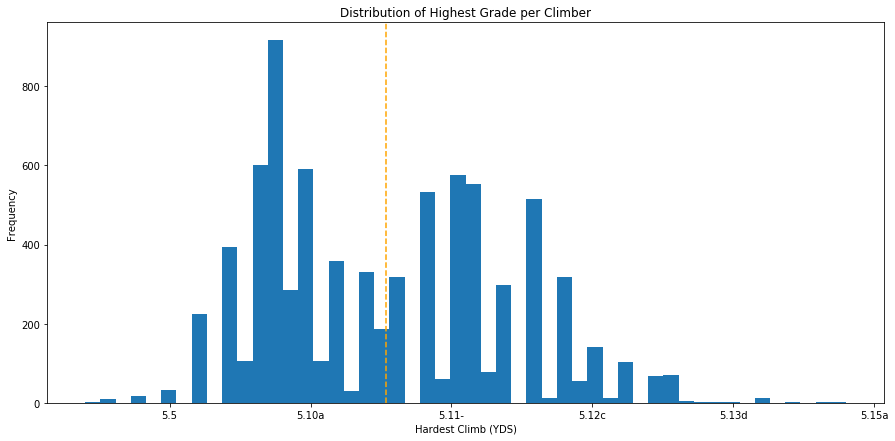

In [7]:
# Examining the distribution in max grades per user
max_grade_per_user = df.groupby('user_id')['grade_encoded'].max()
max_grade_per_user = max_grade_per_user.reset_index()
inverse_route_difficulty_encoding = {v: k for k, v in route_difficulty_encoding.items()}
max_grade_per_user['grade'] = max_grade_per_user['grade_encoded'].replace(inverse_route_difficulty_encoding)

# Plotting and setting the labels to the YDS
ax = max_grade_per_user['grade_encoded'].plot.hist(figsize=(15, 7), bins=50)
labels = ax.get_xticks().tolist()
updated_labels = [inverse_route_difficulty_encoding[label] for label in labels if label <= 33 and label >= 0]
ax.set_xticklabels(updated_labels)
plt.title('Distribution of Highest Grade per Climber')
plt.xlabel('Hardest Climb (YDS)')
plt.axvline(x=max_grade_per_user['grade_encoded'].mean(), linestyle='--', color='orange')
plt.show()

In [ ]:
df.head()

route_matrix = df.pivot_table(index='user_id', columns='route_name', values='rating')
route_matrix.head()

## Testing a recommender system with Surprise!

https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration

In [8]:
import surprise

reader = surprise.Reader(rating_scale=(1, 4))
data = surprise.Dataset.load_from_df(df[['user_id', 'route_id', 'rating']], reader=reader)

surprise.model_selection.cross_validate(surprise.BaselineOnly(), data, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6315  0.6404  0.6303  0.6334  0.6290  0.6329  0.0040  
MAE (testset)     0.5011  0.5093  0.5006  0.5027  0.5003  0.5028  0.0034  
Fit time          0.18    0.19    0.18    0.19    0.20    0.19    0.01    
Test time         0.10    0.13    0.09    0.09    0.15    0.11    0.03    


{'test_rmse': array([0.63153897, 0.6404152 , 0.63027975, 0.63337018, 0.62898736]),
 'test_mae': array([0.50105463, 0.50930766, 0.50063292, 0.50269974, 0.50025555]),
 'fit_time': (0.17799901962280273,
  0.18999958038330078,
  0.18200016021728516,
  0.18600010871887207,
  0.19900059700012207),
 'test_time': (0.09600257873535156,
  0.13499903678894043,
  0.08599996566772461,
  0.08699917793273926,
  0.14699745178222656)}

In [9]:
trainset, testset = train_test_split(data, test_size=.25)

algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

NameError: name 'train_test_split' is not defined

In [106]:
sim_options = {'user_based': False}  # compute  similarities between items
algo = surprise.KNNBasic(sim_options=sim_options)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7621


0.7621227208798315

In [109]:
pd.DataFrame(predictions)

,uid,iid,r_ui,est,details
0,2866,105821892,3.0,3.252018,"{'actual_k': 5, 'was_impossible': False}"
1,153,105732509,3.0,2.681605,"{'actual_k': 24, 'was_impossible': False}"
2,1995,105732242,3.0,3.000000,"{'actual_k': 1, 'was_impossible': False}"
3,485,105732527,3.0,2.488159,"{'actual_k': 40, 'was_impossible': False}"
4,1893,106416528,2.0,2.164295,"{'actual_k': 5, 'was_impossible': False}"
5,4264,108963551,2.0,3.021793,"{'actual_k': 40, 'was_impossible': False}"
6,6499,105913834,3.0,3.202820,"{'actual_k': 9, 'was_impossible': False}"
7,2504,105732401,4.0,2.733961,"{'actual_k': 3, 'was_impossible': False}"
8,358,105733163,3.0,3.144169,"{'actual_k': 36, 'was_impossible': False}"
9,708,105732257,1.0,2.688048,"{'actual_k': 20, 'was_impossible': False}"


---
Examples from the surprise library documentation

In [11]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

# Load the movielens-100k dataset (download it if needed),
data = Dataset.load_builtin('ml-100k')

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9370


0.9370367287386839

### Training w/ LightFm

In [95]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

# Load the MovieLens 100k dataset. Only five
# star ratings are treated as positive.
data = fetch_movielens(min_rating=5.0)

# Instantiate and train the model
model = LightFM(loss='warp')
model.fit(data['train'], epochs=30, num_threads=2)

# Evaluate the trained model
test_precision = precision_at_k(model, data['test'], k=5).mean()

C:\ProgramData\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [98]:
data['train'].

<943x1682 sparse matrix of type '<class 'numpy.float32'>'
	with 19048 stored elements in COOrdinate format>

## Training with just scipy & sklearn

https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea